Input images for this are from the diffIm_demo DECAM data that Yusra gave me. 
First, I ran `imageDifference.py` with `doDecorrelation = False`. Then copied the diffim to the current directory:
```
cp decamDirTest/deepDiff/v289820/diffexp-11.fits .
```
Then I ran it with `doDecorrelation = True`, so the decorrelated diffim now lies in:
```
decamDirTest/deepDiff/v289820/diffexp-11.fits
```

I will note also, that without the correction, at 5.5 sigma, 58,98 positive,negative sources were detected.

With the correction it is only 38,15 (also at 5.5 sigma, though).
At 5.0 sigma on the decorrelated image we get 43,20 detections.

In [13]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.stats

#  LSST imports:
import lsst.afw.image as afwImage
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit
import lsst.ip.diffim.imageDecorrelation as id

reload(dit)
reload(id);

In [2]:
im1 = afwImage.ExposureF('diffexp-11.fits')
im2 = afwImage.ExposureF('decamDirTest/deepDiff/v289820/diffexp-11.fits')

# Also load the original science and template images
sciImg = afwImage.ExposureF('calexpDir_b1631/0289820/calexp/calexp-0289820_11.fits')
templImg = afwImage.ExposureF('calexpDir_b1631/0288976/calexp/calexp-0288976_11.fits')

In [16]:
print 'Stats of variance planes:'
print dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance(),
                                maskIm=sciImg.getMaskedImage().getMask())  # mean, std, var
print dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance(),
                                maskIm=templImg.getMaskedImage().getMask())
print dit.computeClippedAfwStats(im1.getMaskedImage().getVariance(),
                                maskIm=im1.getMaskedImage().getMask())
print dit.computeClippedAfwStats(im2.getMaskedImage().getVariance(),
                                maskIm=im2.getMaskedImage().getMask())

print '\nStats of image pixels:'
print dit.computeClippedAfwStats(sciImg.getMaskedImage())
print dit.computeClippedAfwStats(templImg.getMaskedImage())
print dit.computeClippedAfwStats(im1.getMaskedImage())
print dit.computeClippedAfwStats(im2.getMaskedImage())

Stats of variance planes:
(62.77782901700841, 2.5060648726354002, 6.280361145857084)
(59.99452575747201, 2.4514634731193685, 6.009673160038477)
(66.87903634374102, 2.5179893368341237, 6.340270300410351)
(130.1551950318814, 4.86229251536921, 23.641888505015434)

Stats of image pixels:
(0.0005585483212044934, 8.311411313575924, 69.07955802343785)
(0.0004579826852987869, 8.164932806235559, 66.66612773034169)
(-0.4661162311167405, 8.61241098523501, 74.17362297859668)
(-0.4827656875624522, 11.938570078134127, 142.5294555105195)


UNCORRECTED: (-0.4661162311167405, 8.61241098523501, 74.17362297859668)
CORRECTED:   (-0.4827656875624522, 11.938570078134127, 142.5294555105195)
8090901 7945066


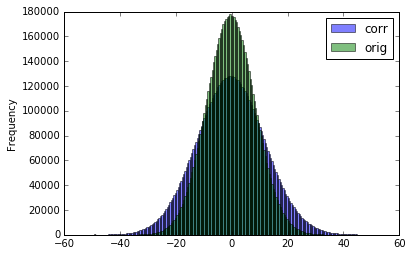

In [14]:
print 'UNCORRECTED:', dit.computeClippedAfwStats(im1.getMaskedImage())
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2.getMaskedImage())
#print 'EXPECTED:   ', np.sqrt(sig1squared + sig2squared)

def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1.getMaskedImage().getImage().getArray())
im2a = getClippedPixels(im2.getMaskedImage().getImage().getArray())
print len(im1a), len(im2a)
im1a = im1a[:len(im2a)]

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a})
df.plot.hist(alpha=0.5, bins=200)

0.349174543978
0.0759764731369


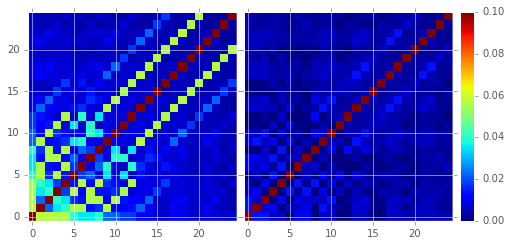

In [15]:
im1a = im1.getMaskedImage().getImage().getArray()
im1a[np.isnan(im1a)|np.isinf(im1a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im1a)
im1a[(im1a < low)|(im1a > upp)] = 0.
cov1 = dit.computePixelCovariance(im1a)

im2a = im2.getMaskedImage().getImage().getArray()
im2a[np.isnan(im2a)|np.isinf(im2a)] = 0.
_, low, upp = scipy.stats.sigmaclip(im2a)
im2a[(im2a < low)|(im2a > upp)] = 0.
cov2 = dit.computePixelCovariance(im2a)

dit.plotImageGrid((cov1, cov2), imScale=4., clim=(0, 0.1), cmap=None)

True
1.99417145453 2.16220999714
1.00014561851 1.0
(14, 14) (14, 15)


DescribeResult(nobs=841, minmax=(-0.0025075321056929681, 0.0055429439426502546), mean=1.7314923479046116e-07, variance=2.6730371985658876e-07, skewness=5.0032314047331825, kurtosis=48.184986228272074)

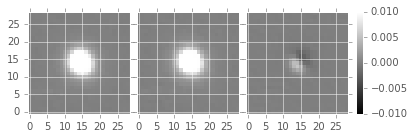

In [16]:
print im2.hasPsf()
im1_psf = im1.getPsf().computeImage().getArray()
im2_psf = im2.getPsf().computeImage().getArray()
print im1.getPsf().computeShape().getDeterminantRadius(), im2.getPsf().computeShape().getDeterminantRadius()
print im1_psf.sum(), im2_psf.sum()
print np.unravel_index(im1_psf.argmax(), im1_psf.shape), np.unravel_index(im2_psf.argmax(), im2_psf.shape)
dit.plotImageGrid((im1.getPsf().computeImage().getArray(), im2_psf, 
                   im1.getPsf().computeImage().getArray() - im2_psf), imScale=2., clim=(-0.01,0.01))
scipy.stats.describe(im1.getPsf().computeImage().getArray() - im2_psf, None)

Here we note that the variance plane appears to be getting set too high in the corrected diffim...?
(130 vs. expected 123...?)

But I think this is too high because we are including the non-convolved pixels (around the edges) in the statistics.
Need to include the masks in the statistics.

SCIENCE: (62.77782901700841, 2.5060648726354002, 6.280361145857084)
TEMPLATE:   (59.99452575747201, 2.4514634731193685, 6.009673160038477)
UNCORRECTED: (66.87903634374102, 2.5179893368341237, 6.340270300410351)
CORRECTED:   (130.1551950318814, 4.86229251536921, 23.641888505015434)
EXPECTED:    122.772354774
7520808 7236304 8087169 8089345


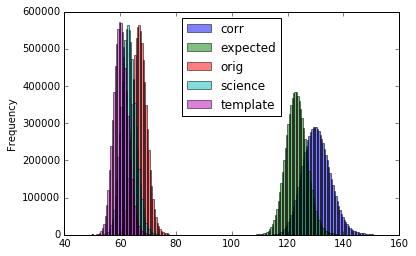

In [14]:
im1a = im1.getMaskedImage().getVariance()
im2a = im2.getMaskedImage().getVariance()
imsa = sciImg.getMaskedImage().getVariance()
imta = templImg.getMaskedImage().getVariance()

tmp = sciImg.getMaskedImage().clone()
tmp -= templImg.getMaskedImage()
tmp = tmp.getVariance()

print 'SCIENCE:', dit.computeClippedAfwStats(imsa, maskIm=sciImg.getMaskedImage().getMask())
print 'TEMPLATE:  ', dit.computeClippedAfwStats(imta, maskIm=templImg.getMaskedImage().getMask())
print 'UNCORRECTED:', dit.computeClippedAfwStats(im1a, maskIm=im1.getMaskedImage().getMask())
print 'CORRECTED:  ', dit.computeClippedAfwStats(im2a, maskIm=im2.getMaskedImage().getMask())
expected = dit.computeClippedAfwStats(imsa, maskIm=sciImg.getMaskedImage().getMask())[0] + \
           dit.computeClippedAfwStats(imta, maskIm=templImg.getMaskedImage().getMask())[0]
print 'EXPECTED:   ', expected

def getClippedPixels(pixels):
    pix = pixels[~(np.isnan(pixels)|np.isinf(pixels))]
    pix = pix[pix != 0.]
    pix, _, _ = scipy.stats.sigmaclip(pix)
    return pix

im1a = getClippedPixels(im1a.getArray())
im2a = getClippedPixels(im2a.getArray())
imsa = getClippedPixels(imsa.getArray())
imta = getClippedPixels(imta.getArray())
tmp = getClippedPixels(tmp.getArray())
print len(im1a), len(im2a), len(imsa), len(imta)
im1a = im1a[:len(im2a)]
imsa = imsa[:len(im2a)]
imta = imta[:len(im2a)]
tmp = tmp[:len(im2a)]
expected = tmp

import pandas as pd
df = pd.DataFrame({'corr': im2a, 'orig': im1a, 'science': imsa, 'template': imta, 'expected': expected})
df.plot.hist(alpha=0.5, bins=200)

See if maybe the variance plane statistics are varying across the images...

Compute statistics across 4 quandrants of the image. They don't seem too bad.

In [46]:
import lsst.afw.geom as afwGeom

def computeVarianceQuadrantStats(im, doPixelsInstead=False):
    im1a = im.getMaskedImage().getVariance()
    if doPixelsInstead:
        im1a = im.getMaskedImage().getImage()
    im1m = im.getMaskedImage().getMask()
    box = im1a.getBBox()
    sz = im1a.getArray().shape
    #print type(im1a), type(im1m)
    #print box, sz
    boxes = [afwGeom.BoxI(afwGeom.PointI(0, 0), afwGeom.PointI(sz[1]//2, sz[0]//2)), # lower left
             afwGeom.BoxI(afwGeom.PointI(sz[1]//2, 0), afwGeom.PointI(sz[1]-1, sz[0]//2)), # lower right
             afwGeom.BoxI(afwGeom.PointI(0, sz[0]//2), afwGeom.PointI(sz[1]/2,sz[0]-1)), # upper left
             afwGeom.BoxI(afwGeom.PointI(sz[1]//2, sz[0]//2), afwGeom.PointI(sz[1]-1, sz[0]-1))] # upper right
    subims = [[afwImage.ImageF(im1a, box, afwImage.PARENT), afwImage.MaskU(im1m, box, afwImage.PARENT)] for box in boxes]
    return [dit.computeClippedAfwStats(sub[0], maskIm=sub[1]) for sub in subims]

print computeVarianceQuadrantStats(im1)
print computeVarianceQuadrantStats(im2)
print;
print computeVarianceQuadrantStats(sciImg)
print computeVarianceQuadrantStats(templImg)

[(66.54960536001707, 2.47325254177236, 6.116978135383438), (67.53822230958895, 2.5319539925768884, 6.4107910205260445), (66.46284778137287, 2.4486658629765206, 5.995964508506549), (66.95278713151625, 2.475458360171577, 6.127894092943354)]
[(129.50556971590996, 4.770142033341396, 22.754255018250387), (131.43633565307007, 4.883518439293218, 23.84875234691687), (129.33648156481567, 4.730536536016902, 22.37797591859079), (130.3065740914836, 4.781548986654983, 22.8632107117813)]

[(62.69091338065344, 2.463967716378212, 6.07113690735406), (63.41873810426934, 2.5304628740989505, 6.403242357193122), (62.38248573840962, 2.43578434927115, 5.93304539615428), (62.62898527894312, 2.479955682621929, 6.1501801877687985)]
[(59.93453036324432, 2.4150648139060262, 5.83253805536695), (60.62246672570823, 2.469627787051983, 6.099061406579276), (59.59632590062195, 2.389932835387278, 5.711778957662275), (59.83809553333399, 2.418117469991334, 5.847292098677291)]


In [47]:
print computeVarianceQuadrantStats(im1, True)
print computeVarianceQuadrantStats(im2, True)
print;
print computeVarianceQuadrantStats(sciImg, True)
print computeVarianceQuadrantStats(templImg, True)

[(-0.451607218866978, 8.626806642387141, 74.42179284513489), (-0.5920733896002717, 8.624696847370492, 74.38539570904251), (-0.3994533439823945, 8.590909918420248, 73.80373322641141), (-0.42003486823754965, 8.605043336834095, 74.04677082879286)]
[(-0.48053740245840965, 11.959234254080453, 143.02328394397125), (-0.6030918653160005, 11.953248127497751, 142.8801407975285), (-0.41179740664168274, 11.90803044002405, 141.80118896053935), (-0.43625532302481856, 11.932985601344614, 142.39614536189785)]

[(-0.00047727846567965503, 8.326378896851708, 69.32858553393746), (0.0001528550975158565, 8.312505837971669, 69.09775330631308), (0.0004661825342090146, 8.302817733763758, 68.93678232010194), (0.0012365038699213703, 8.304268987285818, 68.96088341319704)]
[(3.666277499855388e-05, 8.199478750459976, 67.2314517792447), (0.0004358935627568044, 8.147266932998624, 66.3779584775328), (0.0011695611459858304, 8.190916589526962, 67.091114576588), (-0.0005091459061906097, 8.121714489782319, 65.962246253540

OK, then let's look at the matching kernel variation across the image.

Ran imageDecorrelation with this code added to dump the spatialKernel (it can be pickled!):

```
cPickle.dump(spatialKernel, gzip.GzipFile('spatialKernel.p.gz', 'wb'))
```

('HERE:', 100)


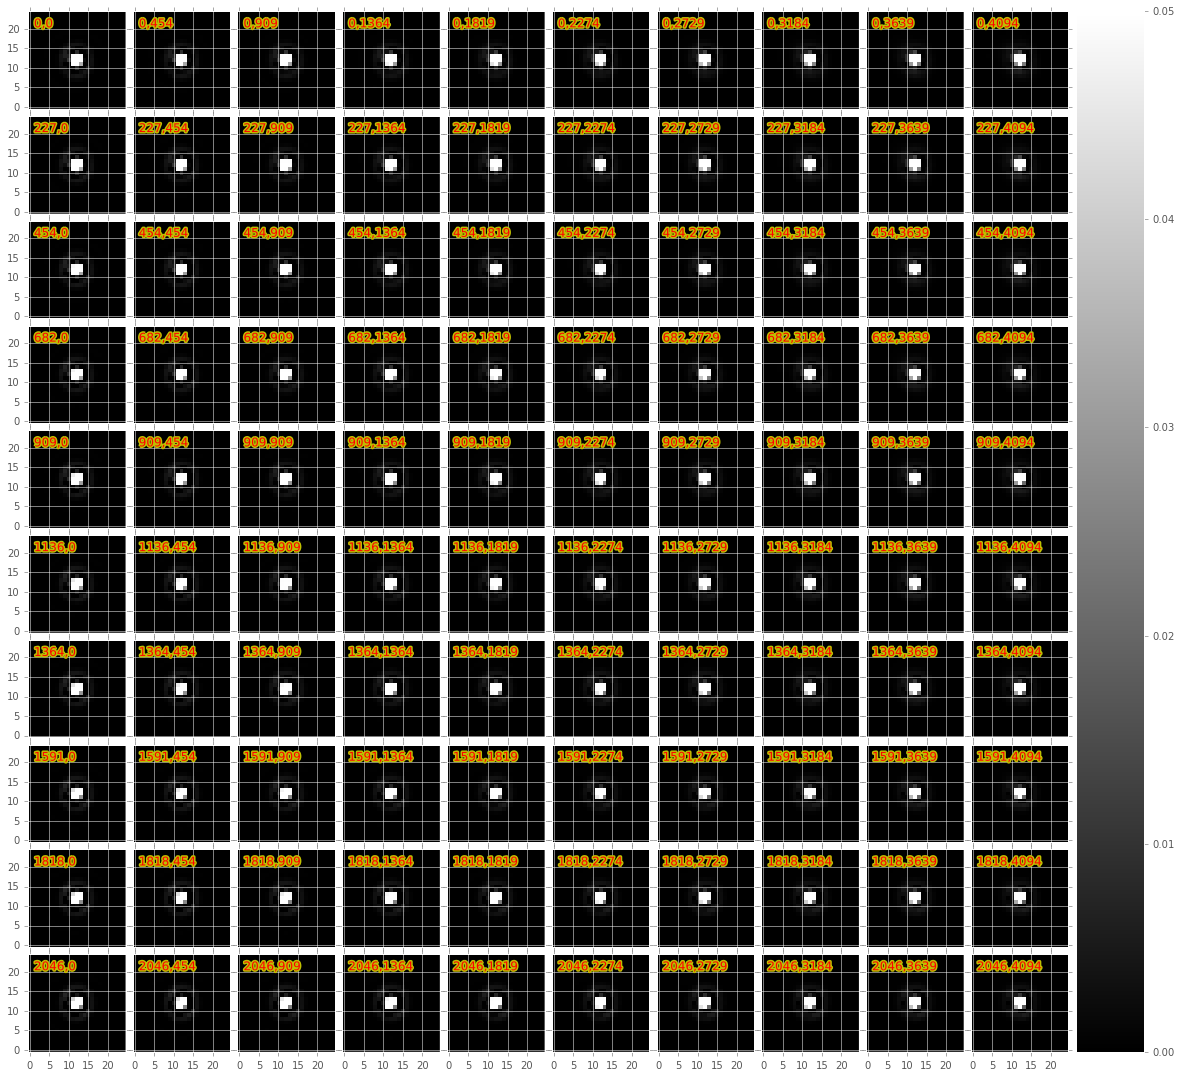

In [82]:
import cPickle
import gzip
bbox = im1a.getBBox()
spatialKernel = cPickle.load(gzip.GzipFile('spatialKernel.p.gz', 'rb'))

def getSpatialKernelImage(spatialKernel, xcen, ycen):
    kimg = afwImage.ImageD(spatialKernel.getDimensions())
    spatialKernel.computeImage(kimg, True, xcen, ycen)
    return kimg.getArray()

kimages = [getSpatialKernelImage(spatialKernel, xc, yc) for
           xc in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for
           yc in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
print "HERE:", len(kimages)

titles = ['%d,%d' % (x,y) for \
          x in np.linspace(bbox.getBeginX(), bbox.getEndX(), 10.) for \
          y in np.linspace(bbox.getBeginY(), bbox.getEndY(), 10.)]
dit.plotImageGrid(kimages, imScale=2., clim=(0., 0.05), titles=titles)

Compute the decorrelation kernel for each of these matching kernels...

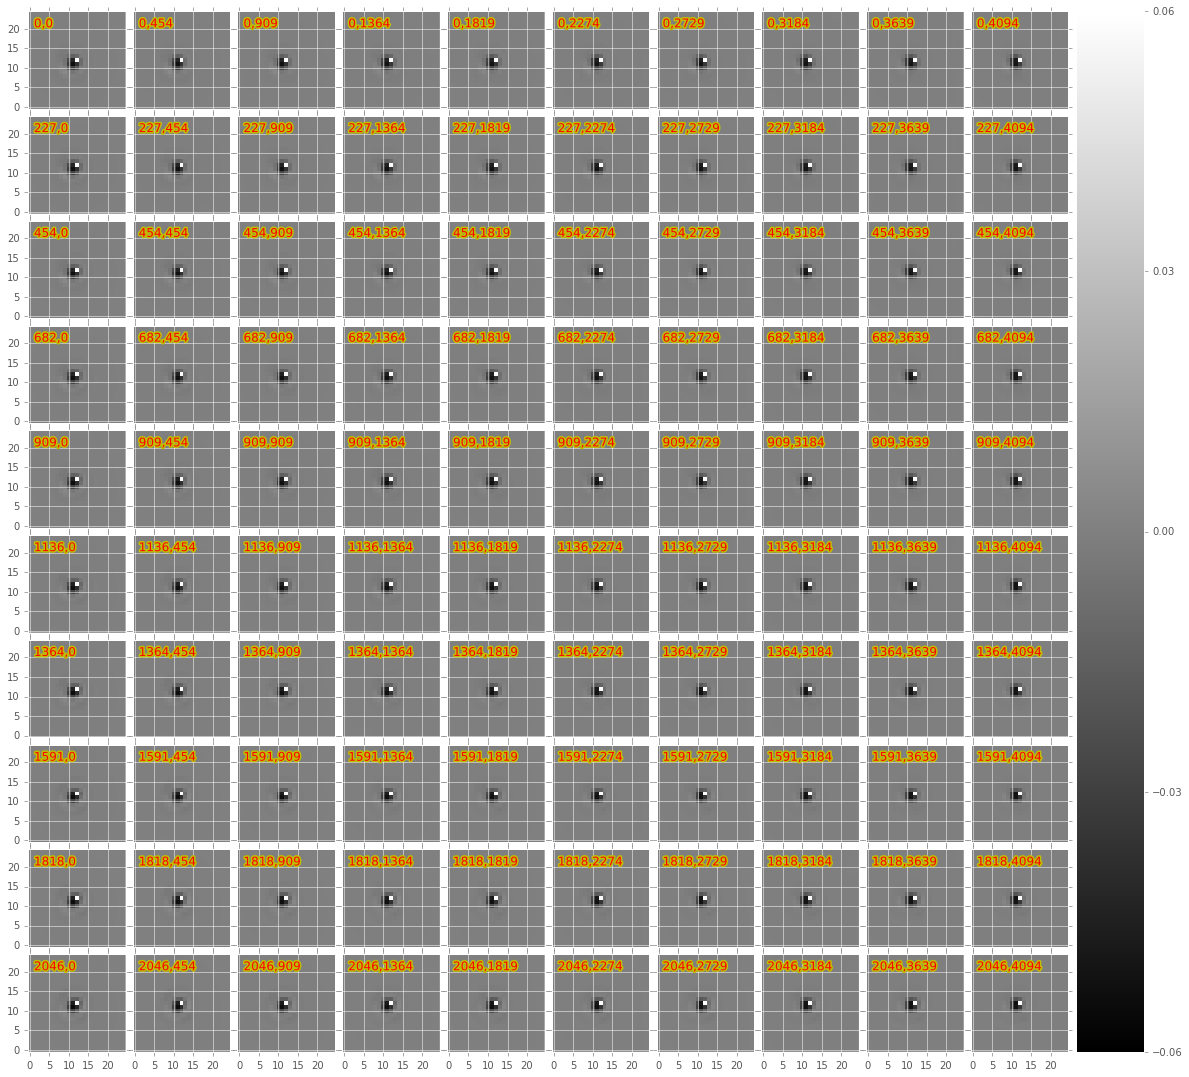

In [83]:
from lsst.ip.diffim import DecorrelateALKernelTask

_, _, var1 = dit.computeClippedAfwStats(sciImg.getMaskedImage().getVariance(),
                                maskIm=sciImg.getMaskedImage().getMask())  # mean, std, var
_, _, var2 = dit.computeClippedAfwStats(templImg.getMaskedImage().getVariance(),
                                maskIm=templImg.getMaskedImage().getMask())

corrKernels = [DecorrelateALKernelTask._computeDecorrelationKernel(kimg, sig1=np.sqrt(var1), sig2=np.sqrt(var2)) \
               for kimg in kimages]
corrKernels = [DecorrelateALKernelTask._fixEvenKernel(kimg) for kimg in corrKernels]
#print [np.max(k) for k in corrKernels]
dit.plotImageGrid(corrKernels, imScale=2., clim=(-0.06, 0.06), titles=titles)

In [86]:
%timeit DecorrelateALKernelTask._computeDecorrelationKernel(kimages[0], sig1=np.sqrt(var1), sig2=np.sqrt(var2))

The slowest run took 4.68 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 183 µs per loop


Find the matching kernels that are the most different, then compare them and their resulting decor. kernels...

0.0861250926096 990 [9, 90]


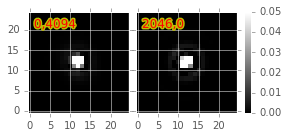

In [84]:
def kernelDiff(k1, k2):
    return np.sqrt(np.sum((k1 - k2)**2.))

diffs = [kernelDiff(k1, k2) for k1 in kimages for k2 in kimages]
coords = [[i, j] for i in range(len(kimages)) for j in range(len(kimages))]
print np.max(diffs), np.argmax(diffs), coords[np.argmax(diffs)]
coo = coords[np.argmax(diffs)]
dit.plotImageGrid([kimages[coo[0]], kimages[coo[1]]], imScale=2., clim=(0., 0.05), 
                  titles=[titles[coo[0]], titles[coo[1]]])

1.37051359044 1.35713685614
1.37051359044 1.35713685614


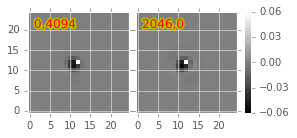

In [89]:
print corrKernels[coo[0]].max(), corrKernels[coo[1]].max()
dit.plotImageGrid([corrKernels[coo[0]], corrKernels[coo[1]]], imScale=2., clim=(-0.06, 0.06), 
                  titles=[titles[coo[0]], titles[coo[1]]])
print np.max([kc.max() for kc in corrKernels]), np.min([kc.max() for kc in corrKernels])

Next step, compute decorr. kernels across the image based on the varying matching kernels AND the varying variances across the images